<a href="https://colab.research.google.com/github/donaldziff/kgqa-ucb-210/blob/main/eda/W210_lc_quad_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ask Wiki Problem definition 
AskWiki must perform 2 tasks sequentially, first is to construct a SPARQL query based on question, second task is to verbalize and generate an answer from the query results. 

Author: shrinivasbjoshi@berkeley.edu

# NL to Sparql Approach 
In the earlier phases of system development, we have analyzed the LC-QuAD dataset which offers around 24K+ [training] natural language queries with corresponding SPARQL queries.  This notebook offers insights into LC-QUAD dataset. 


# LC_QUAD data setup  

## Set up

In [ ]:
# Google collab premium utilities status check
# GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

print( '\n')

# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')

Not connected to a GPU


Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
cd /content/drive/MyDrive/W210

[Errno 2] No such file or directory: '/content/drive/MyDrive/W210'
/content


In [ ]:
!pwd

/content


In [ ]:
!wget https://raw.githubusercontent.com/AskNowQA/LC-QuAD2.0/master/dataset/train.json
!wget https://raw.githubusercontent.com/AskNowQA/LC-QuAD2.0/master/dataset/test.json

--2023-02-25 23:46:32--  https://raw.githubusercontent.com/AskNowQA/LC-QuAD2.0/master/dataset/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26561843 (25M) [text/plain]
Saving to: ‘train.json’

train.json          100%[===================>]  25.33M   101MB/s    in 0.3s    

2023-02-25 23:46:33 (101 MB/s) - ‘train.json’ saved [26561843/26561843]

--2023-02-25 23:46:33--  https://raw.githubusercontent.com/AskNowQA/LC-QuAD2.0/master/dataset/test.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6578362 (6.3M) [text/pla

In [ ]:
#import libraries
import io
import pandas as pd
import numpy as np

In [ ]:
!pwd

/content


In [ ]:
#Get the dataset
TRAIN_URL = 'https://raw.githubusercontent.com/AskNowQA/LC-QuAD2.0/master/dataset/train.json'

In [ ]:
train_df= pd.read_json(TRAIN_URL)

In [ ]:
train_df.head()

,NNQT_question,uid,subgraph,template_index,question,sparql_wikidata,sparql_dbpedia18,template,answer,template_id,paraphrased_question
0,What is the {periodical literature} for {mouth...,19719,simple question right,65,What periodical literature does Delta Air Line...,select distinct ?obj where { wd:Q188920 wdt:P...,select distinct ?obj where { ?statement <http:...,<S P ?O ; ?O instanceOf Type>,[],1,What is Delta Air Line's periodical literature...
1,What is {child of} of {husband} of {Ranavalona...,15554,left-subgraph,8,Who is the child of Ranavalona I's husband?,SELECT ?answer WHERE { wd:Q169794 wdt:P26 ?X ....,SELECT ?answer WHERE { ?statement1 <http://www...,C RCD xD . xD RDE ?E,[],5,What is the name of Ranavalona I's husband's c...
2,Did {Jeff_Bridges} {occupation} {Lane Chandler...,974,boolean double one_hop right subgraph,474,Is it true Jeff_Bridges occupation Lane Chandl...,ASK WHERE { wd:Q174843 wdt:P106 wd:Q1804811 . ...,ASK { ?statement1 <http://www.w3.org/1999/02/...,Ask (ent-pred-obj1` . ent-pred-obj2),[],2,Are Jeff Bridges and Lane Chandler both photog...
3,What is {prequel of} of {phase of matter} of {...,15803,right-subgraph,33,What is the pre-requisite of phase matter of G...,SELECT ?answer WHERE { wd:Q675176 wdt:P515 ?X ...,SELECT ?answer WHERE { ?statement1 <http://www...,E REF xF . xF RFG ?G,[],2,What range are the papers at the Monique Genon...
4,What is <operating income> of <Qantas> ?,27610,center,1907,Which is the operating income for Qantas?,select distinct ?answer where { wd:Q32491 wdt:...,select distinct ?answer where { ?statement <ht...,E REF ?F,[],1.1,[]


In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(train_df)

,NNQT_question,uid,subgraph,template_index,question,sparql_wikidata,sparql_dbpedia18,template,answer,template_id,paraphrased_question
0,What is the {periodical literature} for {mouthpiece} of {Delta Air Lines},19719,simple question right,65,What periodical literature does Delta Air Lines use as a moutpiece?,select distinct ?obj where { wd:Q188920 wdt:P2813 ?obj . ?obj wdt:P31 wd:Q1002697 },select distinct ?obj where { ?statement <http://www.w3.org/1999/02/22-rdf-syntax-ns#subject> <http://wikidata.dbpedia.org/resource/Q188920> . ?statement <http://www.w3.org/1999/02/22-rdf-syntax-ns#predicate> <http://www.wikidata.org/entity/P2813> . ?statement <http://www.w3.org/1999/02/22-rdf-syntax-ns#object> ?obj . ?obj <http://www.wikidata.org/entity/P31> <http://wikidata.dbpedia.org/resource/Q1002697> },<S P ?O ; ?O instanceOf Type>,[],1,What is Delta Air Line's periodical literature mouthpiece?
1,What is {child of} of {husband} of {Ranavalona I} ?,15554,left-subgraph,8,Who is the child of Ranavalona I's husband?,SELECT ?answer WHERE { wd:Q169794 wdt:P26 ?X . ?X wdt:P22 ?answer},SELECT ?answer WHERE { ?statement1 <http://www.w3.org/1999/02/22-rdf-syntax-ns#subject> <http://wikidata.dbpedia.org/resource/Q169794> . ?statement1 <http://www.w3.org/1999/02/22-rdf-syntax-ns#predicate> <http://www.wikidata.org/entity/P26>. ?statement1 <http://www.w3.org/1999/02/22-rdf-syntax-ns#object> ?X . ?statement2 <http://www.w3.org/1999/02/22-rdf-syntax-ns#subject> ?X. ?statement2 <http://www.w3.org/1999/02/22-rdf-syntax-ns#predicate> <http://www.wikidata.org/entity/P22> . ?statement2 <http://www.w3.org/1999/02/22-rdf-syntax-ns#object> ?answer . },C RCD xD . xD RDE ?E,[],5,What is the name of Ranavalona I's husband's child?
2,Did {Jeff_Bridges} {occupation} {Lane Chandler} and {photographer} ?,974,boolean double one_hop right subgraph,474,Is it true Jeff_Bridges occupation Lane Chandler and photographer ?,ASK WHERE { wd:Q174843 wdt:P106 wd:Q1804811 . wd:Q174843 wdt:P106 wd:Q33231 },ASK { ?statement1 <http://www.w3.org/1999/02/22-rdf-syntax-ns#subject> <http://wikidata.dbpedia.org/resource/Q174843> . ?statement1 <http://www.w3.org/1999/02/22-rdf-syntax-ns#predicate> <http://www.wikidata.org/entity/P106> . ?statement1 <http://www.w3.org/1999/02/22-rdf-syntax-ns#object> <http://wikidata.dbpedia.org/resource/Q1804811>. ?statement2 <http://www.w3.org/1999/02/22-rdf-syntax-ns#subject> <http://wikidata.dbpedia.org/resource/Q174843> . ?statement2 <http://www.w3.org/1999/02/22-rdf-syntax-ns#predicate> <http://www.wikidata.org/entity/P106> . ?statement2 <http://www.w3.org/1999/02/22-rdf-syntax-ns#object> <http://wikidata.dbpedia.org/resource/Q33231>. },Ask (ent-pred-obj1` . ent-pred-obj2),[],2,Are Jeff Bridges and Lane Chandler both photographers?
3,What is {prequel of} of {phase of matter} of {Galinstan} ?,15803,right-subgraph,33,What is the pre-requisite of phase matter of Galinstan?,SELECT ?answer WHERE { wd:Q675176 wdt:P515 ?X . ?X wdt:P156 ?answer},SELECT ?answer WHERE { ?statement1 <http://www.w3.org/1999/02/22-rdf-syntax-ns#subject> <http://wikidata.dbpedia.org/resource/Q675176> . ?statement1 <http://www.w3.org/1999/02/22-rdf-syntax-ns#predicate> <http://www.wikidata.org/entity/P515>. ?statement1 <http://www.w3.org/1999/02/22-rdf-syntax-ns#object> ?X . ?statement2 <http://www.w3.org/1999/02/22-rdf-syntax-ns#subject> ?X. ?statement2 <http://www.w3.org/1999/02/22-rdf-syntax-ns#predicate> <http://www.wikidata.org/entity/P156> . ?statement2 <http://www.w3.org/1999/02/22-rdf-syntax-ns#object> ?answer . },E REF xF . xF RFG ?G,[],2,What range are the papers at the Monique Genonceaux about?
4,What is <operating income> of <Qantas> ?,27610,center,1907,Which is the operating income for Qantas?,select distinct ?answer where { wd:Q32491 wdt:P3362 ?answer},select distinct ?answer where { ?statement <http://www.w3.org/1999/02/22-rdf-syntax-ns#subject> <http://wikidata.dbpedia.org/resource/Q32491> . ?statement <http://www.w3.org/1999/02/22-rdf-syntax-ns#predicate> <http://

In [ ]:
#Clean the data
train_df = train_df.dropna()

In [ ]:
train_df.isnull().sum()

NNQT_question           0
uid                     0
subgraph                0
template_index          0
question                0
sparql_wikidata         0
sparql_dbpedia18        0
template                0
answer                  0
template_id             0
paraphrased_question    0
dtype: int64

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24124 entries, 0 to 24179
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   NNQT_question         24124 non-null  object
 1   uid                   24124 non-null  int64 
 2   subgraph              24124 non-null  object
 3   template_index        24124 non-null  int64 
 4   question              24124 non-null  object
 5   sparql_wikidata       24124 non-null  object
 6   sparql_dbpedia18      24124 non-null  object
 7   template              24124 non-null  object
 8   answer                24124 non-null  object
 9   template_id           24124 non-null  object
 10  paraphrased_question  24124 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.2+ MB


In [ ]:
train_df[:1]

,NNQT_question,uid,subgraph,template_index,question,sparql_wikidata,sparql_dbpedia18,template,answer,template_id,paraphrased_question
0,What is the {periodical literature} for {mouth...,19719,simple question right,65,What periodical literature does Delta Air Line...,select distinct ?obj where { wd:Q188920 wdt:P...,select distinct ?obj where { ?statement <http:...,<S P ?O ; ?O instanceOf Type>,[],1,What is Delta Air Line's periodical literature...


In [ ]:
#Install and import additional libraries for plotting
!pip install seaborn
import seaborn as sns
import sklearn as sklearn


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 565.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 2.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.1
    Uninstalling matplotlib-3.6.1:
      Successfully uninstalled matplotlib-3.6.1

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [ ]:
#Install and import additional libraries for EDA 
!pip install spacy
!pip install empath
from empath import Empath
lexicon = Empath()
# Import module
!pip install NRCLex
from nrclex import NRCLex
import nltk
nltk.download('punkt')
import collections
from collections import Counter
import spacy
!python3.10 -m spacy download en_core_web_sm
import en_core_web_sm
nlp = en_core_web_sm.load()


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


[nltk_data] Downloading package punkt to /home/jstil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!pip install textstat
from textstat import flesch_reading_ease


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 938.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.0 MB/s eta 0:00:00a 0:00:010m

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


## Perform additional data transformations

In [ ]:
train_df['lexicon'] = train_df['question'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
#train_df['emotions'] = train_df['question'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
#train_df['postags'] =  train_df['question'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
  

In [ ]:
#get lexicon of the question
train_df['lexicon_key'] = train_df['question'].apply(lambda x: ', '.join(f'{key}' for key, value in lexicon.analyze(x).items() if value > 0))

In [ ]:
#get emotions and part of speech
train_df['emotions_key'] = train_df['question'].apply(lambda x: ', '.join(f'{key}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
train_df['postags_key'] =  train_df['question'].apply(lambda x: ', '.join(f'{key.lower()}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
  

In [ ]:
#get entity listings of the question
train_df['entity_key'] =  train_df['question'].apply(lambda x: ', '.join(f'{key.lower()}' for key, value in Counter((token.label_ for token in (nlp(x)).ents)).items()))

#EDA


### We have question word length that is about 100 words, 200 max

<AxesSubplot:>

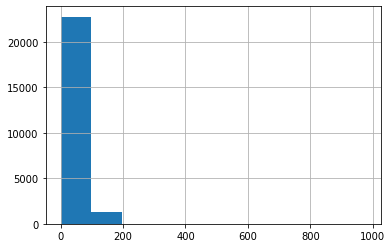

In [ ]:
train_df['question'].str.len().hist()

### avg word length in each question is about 4-6 range

<AxesSubplot:>

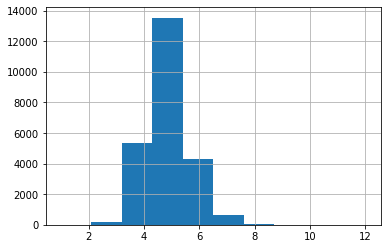

In [ ]:
train_df['question'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

In [ ]:
#analyze words in each question 
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
corpus=[]
question= train_df['question'].str.split()
question=question.values.tolist()
corpus=[word.lower() for i in question for word in i]
stop=set(stopwords.words('english'))
qw = ['what', 'which', 'when', 'where', 'who', 'whom', 'whose', 'why', 'whether', 'how']
from collections import defaultdict
dic=defaultdict(int)
q =defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
    if word in qw:
        q[word]+=1

[nltk_data] Downloading package stopwords to /home/jstil/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<BarContainer object of 10 artists>

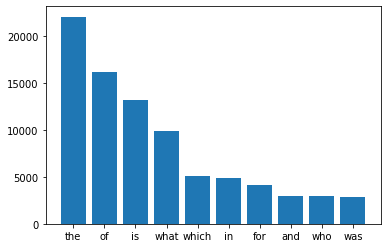

In [ ]:
#plot stop words
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

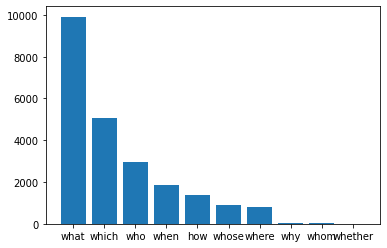

In [ ]:
#plot introgative words
top_q=sorted(q.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top_q)
plt.bar(x,y)

### Subgraph statistics..to be explored further


<AxesSubplot:>

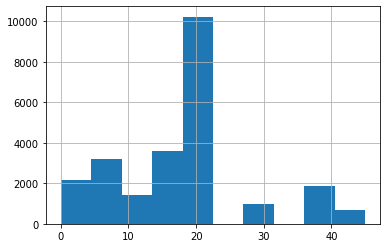

In [ ]:
train_df['subgraph'].str.len().hist()

<Axes: >

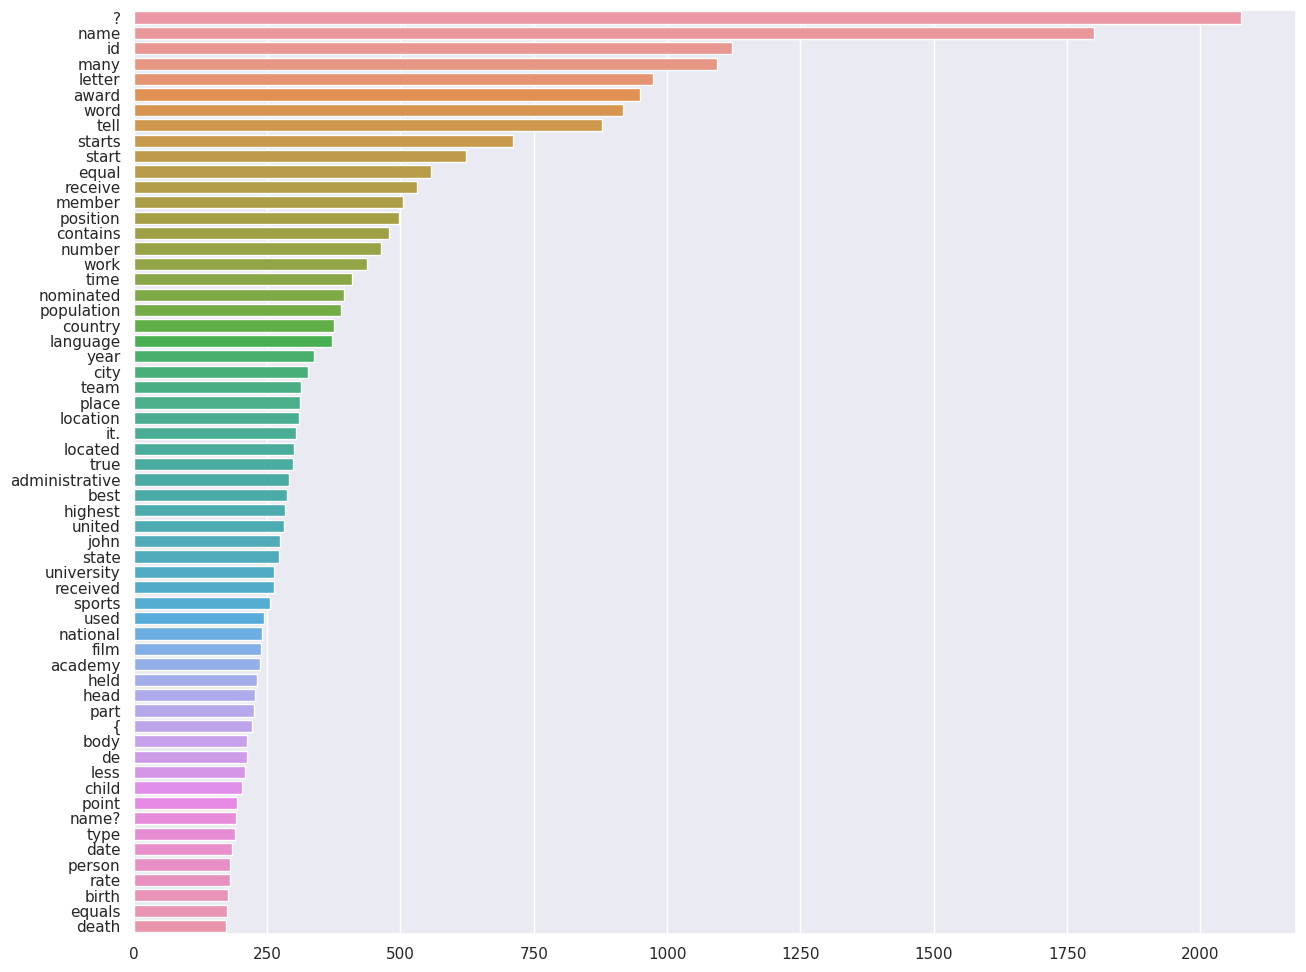

In [ ]:
#freq of non stop words in NL questions
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:100]:
    if (word not in stop and word not in qw):
        x.append(word)
        y.append(count)
sns.set(rc={'figure.figsize':(15,12)})
sns.barplot(x=y,y=x)

<Axes: >

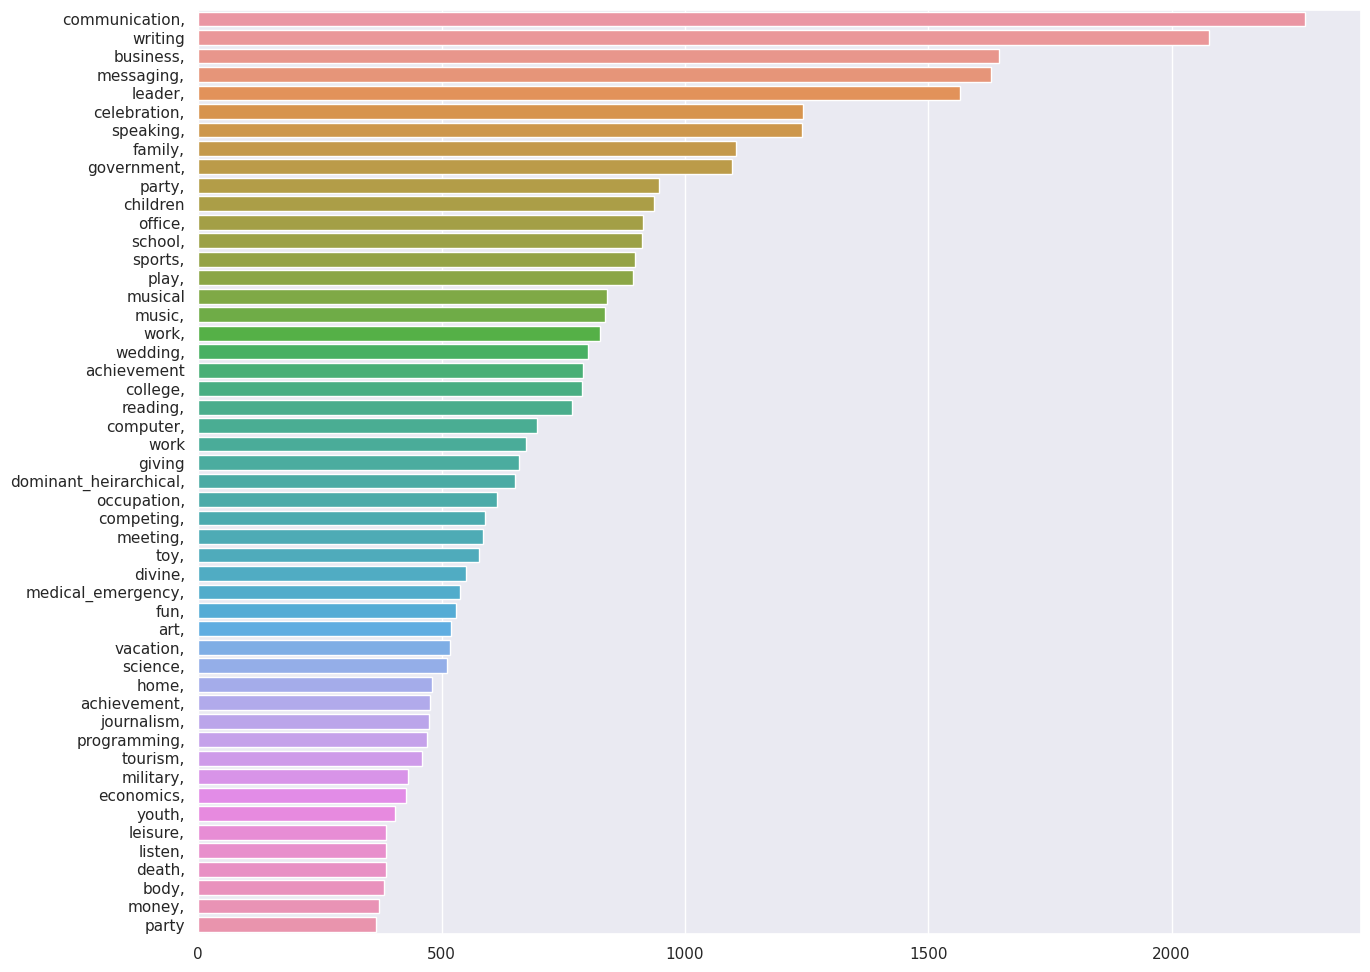

In [ ]:
#topics
lex = Counter([ word.lower() for i in train_df['lexicon_key'].str.split().values.tolist() for word in i])
x, y= [], []
most_lex=lex.most_common()
for word,count in most_lex[:50]:
    x.append(word)
    y.append(count)
sns.set(rc={'figure.figsize':(15,12)})
sns.barplot(x=y,y=x)

In [ ]:
# get lexicon dataset
#train_df.head()
train_df['lexicon_set'] = [set(x.split(", ")) for x in train_df['lexicon_key']]
train_df.head()

sports_indices = {row['uid']  if 'sports' in row['lexicon_set'] else '0' for i, row in train_df.iterrows()}
train_df[train_df['uid'].isin(sports_indices)].head(100)
#sports_subset = train_df[train_df['uid'].isin(sports_indices)]

,NNQT_question,uid,subgraph,template_index,question,sparql_wikidata,sparql_dbpedia18,template,answer,template_id,paraphrased_question,lexicon,emotions,postags,lexicon_key,lexicon_set
8,What is <International Olympic Committee athle...,26800,center,1097,What's Mary Lou Retton's International Olympic...,select distinct ?answer where { wd:Q235975 wdt...,select distinct ?answer where { ?statement <ht...,E REF ?F,[],1.1,[],"sports 1.0, competing 1.0",positive 1,"pron 1, aux 1, propn 7, part 1, noun 1, punct 1","sports, competing","{competing, sports}"
12,Did {Lindsey_Vonn} {participant of} {FIS Alpin...,519,boolean double one_hop right subgraph,19,Did Lindsey Vonn participate in the FIS Alpine...,ASK WHERE { wd:Q10068 wdt:P1344 wd:Q1428251 . ...,ASK { ?statement1 <http://www.w3.org/1999/02/...,Ask (ent-pred-obj1` . ent-pred-obj2),[],2,"In 1999 and 2019, was Lindsey Vonn in the FIS ...","school 1.0, play 1.0, sports 1.0, fight 1.0, m...",,"aux 1, propn 7, verb 1, adp 2, det 1, num 2, c...","school, play, sports, fight, meeting, party","{play, school, fight, party, sports, meeting}"
17,Did {Judi_Dench} {award received} {Tony Award ...,712,boolean double one_hop right subgraph,212,Did Judi Densch receive a Tony Award for best ...,ASK WHERE { wd:Q28054 wdt:P166 wd:Q640374 . wd...,ASK { ?statement1 <http://www.w3.org/1999/02/...,Ask (ent-pred-obj1` . ent-pred-obj2),[],2,Was the Tony Award for best direction of the p...,"family 1.0, leisure 1.0, play 1.0, sports 1.0,...",,"aux 1, propn 6, verb 1, det 2, adp 2, adj 1, n...","family, leisure, play, sports, music, toy, fun...","{family, play, fun, giving, leisure, messaging..."
20,What is {played by} of {succeded by} of {Sleep...,15164,left-subgraph,86,Who Sleepwalking succeeded in playing Sleepwal...,SELECT ?answer WHERE { wd:Q7539946 wdt:P156 ?X...,SELECT ?answer WHERE { ?statement1 <http://www...,C RCD xD . xD RDE ?E,[],5,Who Sleepwalking succeeded in playing Sleepwal...,"play 1.0, sports 1.0, toy 1.0, listen 1.0, chi...",,"pron 1, verb 3, adp 1, propn 1, punct 1","play, sports, toy, listen, children, musical","{play, listen, toy, sports, musical, children}"
42,What is the {medal} for {award received} of {A...,29959,simple question right,1550,What is the medal Angela Lansbury recieved?,select distinct ?obj where { wd:Q206856 wdt:P...,select distinct ?obj where { ?statement <http:...,<S P ?O ; ?O instanceOf Type>,[],1,[],"sports 1.0, competing 1.0, achievement 1.0","anticipation 1, joy 1, positive 1, surprise 1,...","pron 1, aux 1, det 1, noun 1, propn 2, verb 1,...","sports, competing, achievement","{competing, sports, achievement}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,What is <review score> of <12 Angry Men> ?,28244,center,2541,Which is the review score for 12 Angry Men?,select distinct ?answer where { wd:Q2345 wdt:P...,select distinct ?answer where { ?statement <ht...,E REF ?F,[],1.1,[],"reading 1.0, sports 1.0, competing 1.0, achiev...","anticipation 1, joy 1, positive 1, surprise 1","pron 1, aux 1, det 1, noun 2, adp 1, num 1, pr...","reading, sports, competing, achievement","{reading, competing, sports, achievement}"
2238,What is {member of sports team} of {Michael Jo...,11435,[],903,Who does Michael Jordan play for and how many ...,SELECT ?value1 ?obj WHERE { wd:Q41421 p:P54 ?s...,select distinct ?dataprop1 ?obj where { ?state...,[],[],3,Who does Michael Jordan play for and how numer...,"leisure 1.0, play 1.0, sports 1.0, music 1.0, ...",,"pron 2, aux 2, propn 2, verb 2, adp 1, cconj 1...","leisure, play, sports, music, toy, fun, musical","{play, fun, leisure, toy, music, sports, musical}"
2258,"What is {craft} of {Steve Gerber}, that has {f...",14146,right-subgraph,3851,"In the field of screenplays, what is Steve Ger...",SELECT ?answer WHERE { wd:Q2569995 wdt:P106 ?a...,SELECT ?answer WHERE { ?statement1 <http://www...,E REF ?F . ?F RFG G,[],1,What is Steve Gerber's craft in the screenplay...,"sports 1.0, hiking 1.0, plant 1.0",positive 1,"adp 2

<AxesSubplot:>

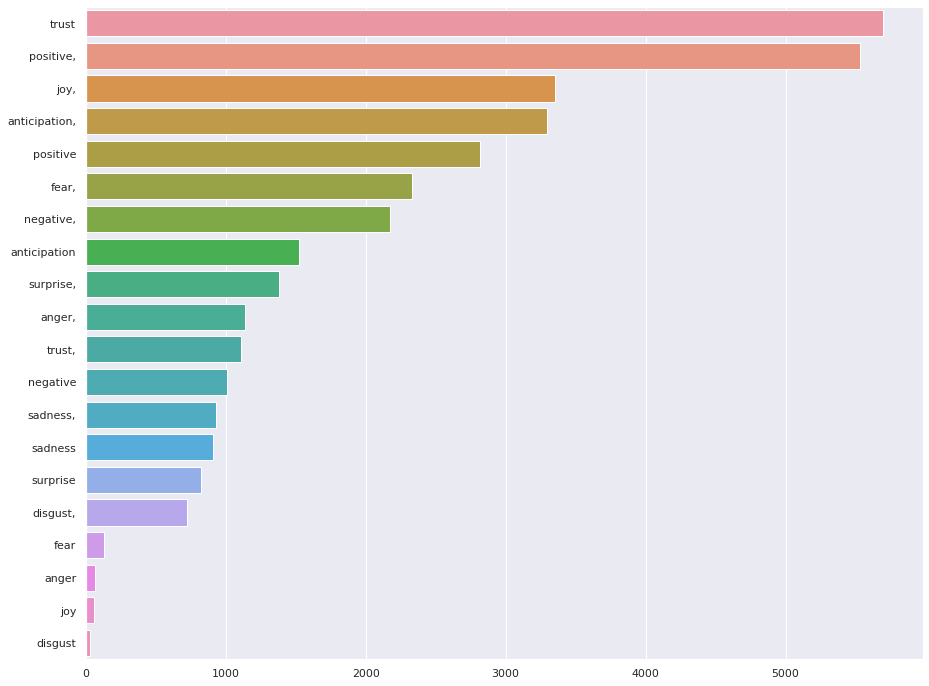

In [ ]:
#Emotions in NL questions
emotions = Counter([ word.lower() for i in train_df['emotions_key'].str.split().values.tolist() for word in i])
x, y= [], []
most_emotions=emotions.most_common()
for word,count in most_emotions[:50]:
  x.append(word)
  y.append(count)
sns.set(rc={'figure.figsize':(15,12)})
sns.barplot(x=y,y=x)

<AxesSubplot:>

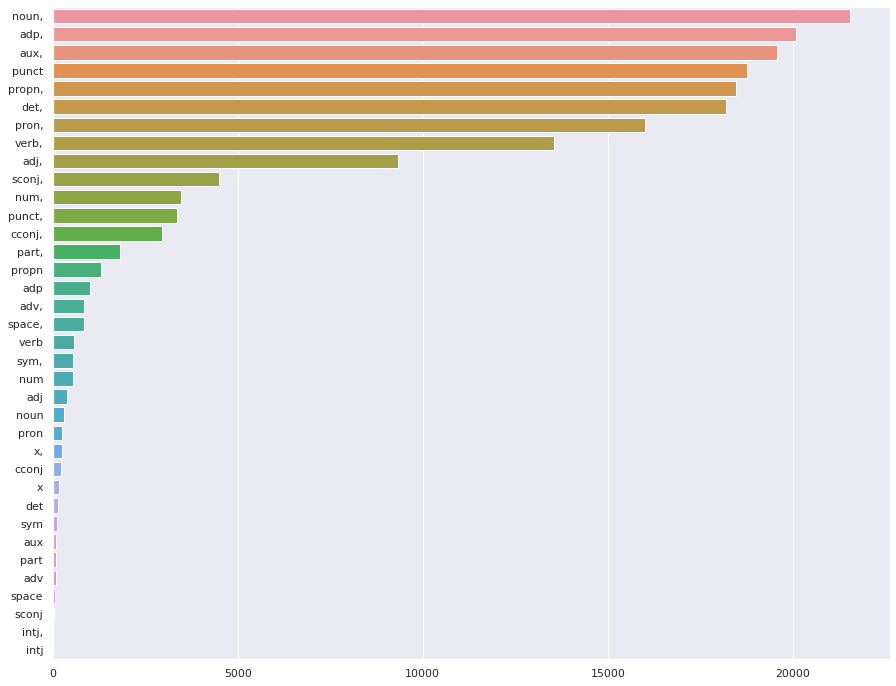

In [ ]:
#part of speech in NL question
pos = Counter([ word.lower() for i in train_df['postags_key'].str.split().values.tolist() for word in i])
x, y= [], []
most_pos=pos.most_common()
for word,count in most_pos[:50]:
  x.append(word)
  y.append(count)
sns.set(rc={'figure.figsize':(15,12)})
sns.barplot(x=y,y=x)

<AxesSubplot:>

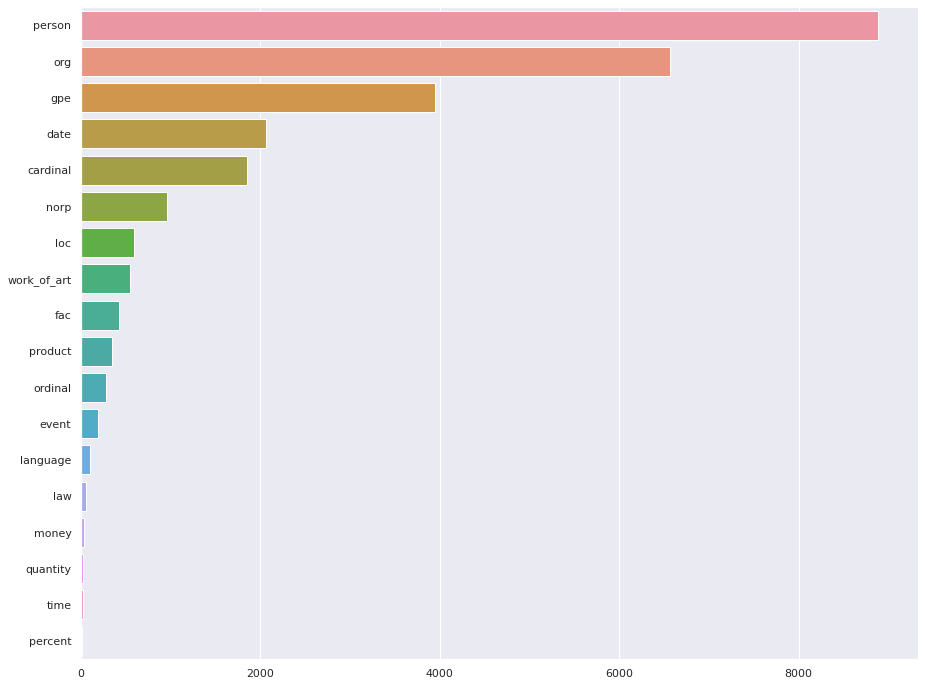

In [ ]:
#entity in NL question
entity = Counter([ word.lower().replace(",","") for i in train_df['entity_key'].str.split().values.tolist() for word in i])
x, y= [], []
most_entity=entity.most_common()
for word,count in most_entity[:50]:
  x.append(word)
  y.append(count)
sns.set(rc={'figure.figsize':(15,12)})
sns.barplot(x=y,y=x)

<AxesSubplot:>

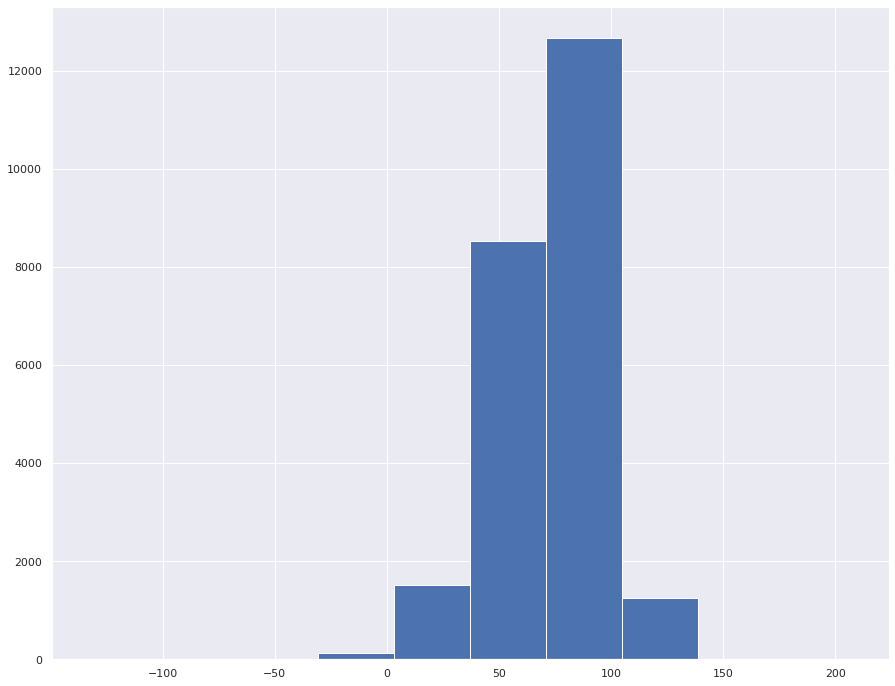

In [ ]:
train_df['question'].apply(lambda x : flesch_reading_ease(x)).hist()

In [ ]:
train_df['ease']=train_df['question'].apply(lambda x : flesch_reading_ease(x))

In [ ]:
train_df['ease']

0         51.85
1         88.74
2         36.96
3         62.34
4         55.91
          ...  
24175     67.76
24176    103.63
24177     84.68
24178     69.79
24179    101.60
Name: ease, Length: 24124, dtype: float64

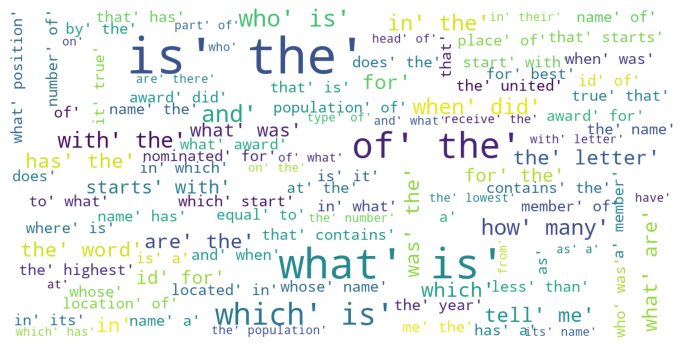

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

# Summary
1. The dataset offers questions across variety of topics, different lexicons, diverse set of entities. 

2. Most questions are about 100 words and avg word length is about 4-6, “WHAT” is the highest available question type

3. Dataset covers 50+ Topics across NL questions, we believe this will help us choose multiple topics from wikidata for our system development and don't necessarily have to limit ourselves to a domain or topic for the MVP
 
4. Higher number of questions towards positive sentiments as compared to negative sentiments. Question set has class imbalance in terms of emotions. This might limit our ability to generate a accurate  sparql for negative sentiment.

5. Diversified named entities are in the dataset, leaning more towards persons in past, organizations, locations and events. Team will continue to explore more data sets [especially news & events] which might offer more balance as well as larger corpus for NL to Sparql training.
